In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

In [72]:
df = pd.read_csv('../content/S02-hw-dataset.csv',header=0).head(1000)
data = df.values

In [73]:
print(df.head())

   user_id   age country  purchases  revenue
0        1  25.0      FR          7      749
1        2  24.0      RU          5     1115
2        3  52.0      FR          7      399
3        4  31.0      RU          6      654
4        5   NaN      DE          6     1296


In [74]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    41 non-null     int64  
 1   age        39 non-null     float64
 2   country    41 non-null     object 
 3   purchases  41 non-null     int64  
 4   revenue    41 non-null     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 1.7+ KB
None


In [75]:
print(df.describe())

         user_id         age  purchases      revenue
count  41.000000   39.000000  41.000000    41.000000
mean   20.243902   36.512821   4.829268   820.048780
std    11.659289   18.304259   2.710189   613.127269
min     1.000000    5.000000  -1.000000     0.000000
25%    10.000000   24.000000   3.000000   432.000000
50%    20.000000   33.000000   5.000000   693.000000
75%    30.000000   45.500000   7.000000  1115.000000
max    40.000000  120.000000  11.000000  2475.000000


In [76]:
missing_ratio = df.isna().mean()
duplicated_rows_count = df.duplicated().sum()
suspicious_purchases = df[df['purchases'] < 0]
suspicious_age = df[(df['age'] > 100) | (df['age'] < 5)]
suspicious_revenue = df[(df['revenue'] == 0) & (df['purchases'] > 0)]
suspicious = pd.concat([suspicious_purchases, suspicious_age, suspicious_revenue]).drop_duplicates()

missing_ratio, duplicated_rows_count, suspicious

(user_id      0.00000
 age          0.04878
 country      0.00000
 purchases    0.00000
 revenue      0.00000
 dtype: float64,
 np.int64(1),
     user_id    age country  purchases  revenue
 5         6  120.0      FR         -1      785
 10       11   24.0      US          4        0)




1.   Доля пропуска не равна 0 лишь в столбце age, который имеет в свою очередь 4.8% пропусков.
2.   Количество дублирующих строк = 1.
3. В датасете содержатся потенциально недостоверные данные, такие как нереалистичный возраст покупателя и логические противоречия между кол-вом покупок и выручкой



In [77]:
df['age_group'] = pd.cut(df['age'], bins=[0, 18, 35, 60, 100], labels=['child/teen', 'young_adult', 'adult', 'senior'])

print(df['age_group'].value_counts())
print()

grouped = df.groupby('age_group').agg(
    avg_purchases=('purchases', 'mean'),
    total_revenue=('revenue', 'sum'),
    user_count=('user_id', 'count'),
    avg_revenue_per_user=('revenue', 'mean')
)
print(grouped)
print()

df['revenue_segment'] = pd.cut(df['revenue'], bins=[0, 300, 800, 1500, df['revenue'].max()],
                               labels=['low', 'medium', 'high', 'very_high'])

print(df['revenue_segment'].value_counts())

age_group
young_adult    21
adult          15
child/teen      2
senior          0
Name: count, dtype: int64

             avg_purchases  total_revenue  user_count  avg_revenue_per_user
age_group                                                                  
child/teen        6.000000           2592           2           1296.000000
young_adult       4.952381          16231          21            772.904762
adult             4.533333          12088          15            805.866667
senior                 NaN              0           0                   NaN

revenue_segment
medium       19
high         11
very_high     5
low           2
Name: count, dtype: int64


/tmp/ipython-input-2330682599.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('age_group').agg(


Доминируют young_adult (21) и adult (15);

child/teen (2 пользователя) — аномально высокая выручка(1296) и покупки(6).
young_adult показывает усредненные показатели: покупки(≈5) выручка(~773).
adult — немного меньше покупок(≈4.5), но чуть выше средняя выручка(~806), чем у young_adult.

senior — 0 записей (кроме аномальной в 120)

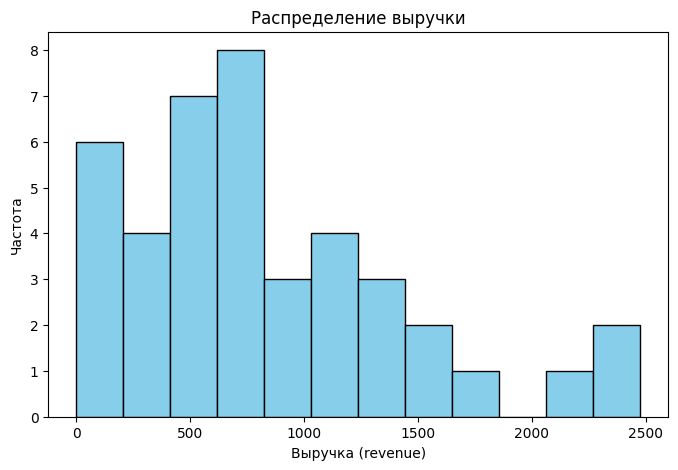

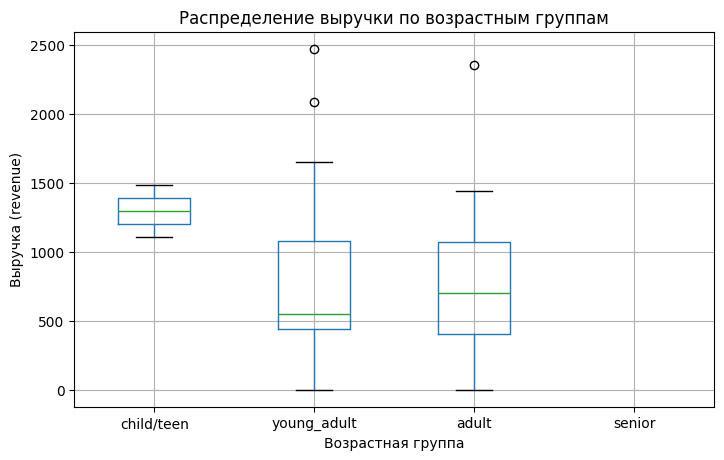

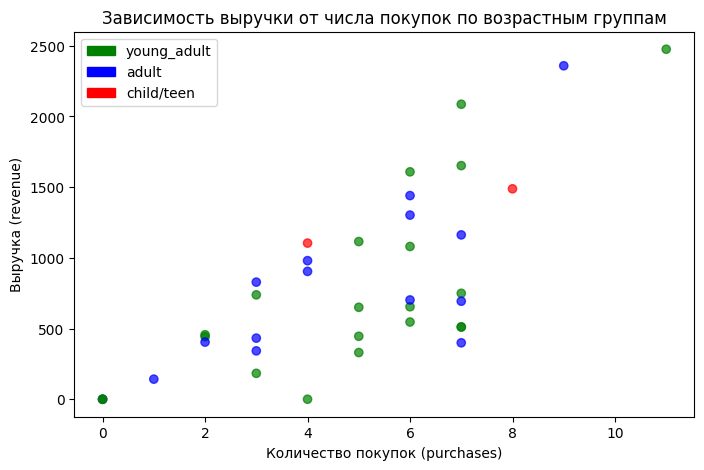

In [78]:
os.makedirs('figures', exist_ok=True) # !!!

plt.figure(figsize=(8, 5))
plt.hist(df['revenue'], bins=12, color='skyblue', edgecolor='black')
plt.xlabel('Выручка (revenue)')
plt.ylabel('Частота')
plt.title('Распределение выручки')
plt.savefig('figures/histogram_revenue.png')
plt.show()

plt.figure(figsize=(8, 5))
df.boxplot(column='revenue', by='age_group', ax=plt.gca())
plt.xlabel('Возрастная группа')
plt.ylabel('Выручка (revenue)')
plt.title('Распределение выручки по возрастным группам')
plt.suptitle('')
plt.savefig('figures/boxplot_revenue_by_age_group.png')
plt.show()

df_clean = df.dropna(subset=['age_group']).copy()
colors = {'child/teen': 'red', 'young_adult': 'green', 'adult': 'blue', 'senior': 'orange'}
df_clean['color'] = df_clean['age_group'].map(colors)

plt.figure(figsize=(8, 5))
plt.scatter(df_clean['purchases'], df_clean['revenue'], c=df_clean['color'], alpha=0.7)

plt.xlabel('Количество покупок (purchases)')
plt.ylabel('Выручка (revenue)')
plt.title('Зависимость выручки от числа покупок по возрастным группам')

unique_labels = df_clean['age_group'].unique()
handles = [mpatches.Patch(color=colors[label], label=label) for label in unique_labels]
plt.legend(handles=handles)

plt.savefig('figures/scatter_purchases_vs_revenue.png')
plt.show()

Графики представляют графические данные очень близкие по содержанию и выводам составленными прежде. Так же прослеживаются аномалии и сравнительная схожесть двух основных групп, с точки зрения выручки, в общем отношении. Тогда как графически более явными становятся определенные усреднения и основы преобладающих значений. Дополнительно график зависимости выручки от числа покупок показывает что не хватает содержания товаров для составления логических цепочек чтобы делать более ощутимые по смыслу выводы, в особенности в рэнжировании выручки относительно 4-6 числа покупок.

Недостаток данных первостепенная проблема данного датасета.